# REBER Grammar with RNN

In this workbook, we are going to set-up multiple Recurrent Neural Network to test them using as test <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words.

## What is a Reber Word ?

A Reber word is a word following the Reber's grammar. The grammar is based on the following graph:

<img src="reber.gif"/>

The word must start with B, then it can be either T or P and so on until it reaches E. To prepare datas for this, we are going to use a OneHotEncoder to have 7 inputs, n timesteps (depending on the length of the word) and k batches. To generate it, I use the algorith from <a href="http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php" target="_target">this site</a> but slightly modified to be able to validate also embedded Word

The Embedded version of the Reber Grammar using the following graph :

<img src="embreber.gif"/>

Due to current technologies, we will focus on Embedded Word (both system tried below with Simple Reber Word reaches 100% success and cannot be compared)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import random

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

Using TensorFlow backend.


## Preparation of datas

For the OneHotEncoder, the chain 'BTSXPVE' will be used. We can now try only 1 example to check the output

In [2]:
x, y = reber.get_one_embedded_example(minLength=10)
print(reber.sequenceToWord(x))
print(x[0], y[0])

BTBPTVPXTTVVET
[ 1.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  1.  0.  0.]


*y* is the possible outcome for a given input. That means B ([ 1.  0.  0.  0.  0.  0.  0.]) can be followed by T or P ([ 0.  1.  0.  0.  1.  0.  0.]).

However, we won't use y as output but for every timestep, we are going to provide the next timestep as target. For this, we will use the following function

Now, if we take as input "BTSXS", the output will be "TSXSE" (but the input in encoded).

We can also generate few words to check the output.

In [3]:
min_length = 25
for i in range(10):
    inp, out = reber.get_one_embedded_example(min_length)
    print(len(inp))

32
30
30
32
31
31
29
29
32
30


In [4]:
def set_wrong(good_seq):
    index = np.random.randint(len(good_seq))
    letter = reber.sequenceToWord([good_seq[index]])
    new_letter = random.choice(list(set("BTSXPVE") - set(letter)))
    bad_seq = good_seq.copy()
    bad_seq[index] = np.array(reber.get_char_one_hot(new_letter)[0])
    return bad_seq

So we have the first "problem" now, the length of the string is variable. So when we are going to generate our test/train datas, we will have to pad them to the same length (let's say 20). This is done by using <b>sequence.pad_sequences</b> for Keras Library. The padding will be done as "post" to improve accuracy. Using a "pre" padding reduce accuracy because the cell doesn't know how many times it will receive 0 instead of "E"

In [58]:
X_train, y_train = [], []
X_test, y_test = [], []
X_eval, y_eval = [], []
y_possible = []

maxlen = 0
min_length = 5
random_state = 42

for i in range(1024):
    x, y = reber.get_one_embedded_example(min_length)
    X_train.append(x)
    y_train.append(1)
    maxlen = max(maxlen, len(x))
    
for i in range(1024):
    x, y = reber.get_one_embedded_example(min_length)
    x = set_wrong(x)
    X_train.append(x)
    y_train.append(0)
    maxlen = max(maxlen, len(x))

for i in range(128):
    x, y = reber.get_one_embedded_example(min_length)
    X_test.append(x)
    y_test.append(1)
    maxlen = max(maxlen, len(x))
    
for i in range(128):
    x, y = reber.get_one_embedded_example(min_length)
    x = set_wrong(x)
    X_test.append(x)
    y_test.append(0)
    maxlen = max(maxlen, len(x))
    
for i in range(128):
    x, y = reber.get_one_embedded_example(min_length)
    X_eval.append(x)
    y_eval.append(1)
    maxlen = max(maxlen, len(x))
    
for i in range(128):
    x, y = reber.get_one_embedded_example(min_length)
    x = set_wrong(x)
    X_eval.append(x)
    y_eval.append(0)
    maxlen = max(maxlen, len(x))
    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_eval = np.array(X_eval)
y_eval = np.array(y_eval)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
X_test, y_test = shuffle(X_test, y_test, random_state=random_state)
X_eval, y_eval = shuffle(X_eval, y_eval, random_state=random_state)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
X_eval = sequence.pad_sequences(X_eval, maxlen=maxlen, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2048, 36, 7)
(2048,)
(256, 36, 7)
(256,)


So now we have 2048 strings for training, 256 for test and 1 just for visualisation later. We can now set-up our model.

## Test of RNNs

For this model, we are going to use a many-to-many RNN. That means for every input, the model will predict an output. The training will be done based on the input we prepared previously. Once trained. We will be able to "transfer" the learning to a one-to-many model in order to have a "generator".

<img src="RNN_types.jpg"/>

What we expect is a probability of having this or this letter. The problem is a multi-class classifier. As a reult, the loss function will be the categorical crossentropy

In [6]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "binary_crossentropy"
metrics_ = "accuracy"
optimizer_ = "Adam"
nb_epoch = 250
batch_size = 64

### LSTM

The first model we will setup is an <b>LSTM</b> which means <b>L</b>ong <b>S</b>hort-<b>T</b>erm <b>M</b>emory. The principle is 
quite complex but very powerfull for long sequences inputs (because there is less issues with Vanishing Gradient Problem) or long term memory (You can refer to <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/" target="_blank">this link</a> for more informations)

LSTM is widely for speech recognition, Natural Language processing, Sentiment Analysis.

In [22]:
model = Sequential()

model.add(LSTM(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model.add(LSTM(units=nb_unit, input_shape=inp_shape))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("lstm_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [17]:
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 36, 7)
Outputs: (None, 1)
Actual input: (2048, 36, 7)
Actual output: (2048,)


In [23]:
start = time.time()
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t1 = stop-start
print(model.summary())
print("Training time : {}s".format(t1))
LSTM_steps = len(history.history["acc"])

Train on 2048 samples, validate on 256 samples
Epoch 1/250
 - 4s - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6930 - val_acc: 0.5039


C:\Anaconda501\lib\site-packages\keras\callbacks.py:402: RuntimeWarning: Can save best model only with binary_crossentropy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/250
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6929 - val_acc: 0.5430
Epoch 3/250
 - 2s - loss: 0.6930 - acc: 0.5083 - val_loss: 0.6927 - val_acc: 0.5039
Epoch 4/250
 - 2s - loss: 0.6927 - acc: 0.5142 - val_loss: 0.6920 - val_acc: 0.5391
Epoch 5/250
 - 2s - loss: 0.6921 - acc: 0.5171 - val_loss: 0.6904 - val_acc: 0.5430
Epoch 6/250
 - 2s - loss: 0.6914 - acc: 0.5396 - val_loss: 0.6891 - val_acc: 0.5664
Epoch 7/250
 - 3s - loss: 0.6922 - acc: 0.5293 - val_loss: 0.6921 - val_acc: 0.5117
Epoch 8/250
 - 3s - loss: 0.6928 - acc: 0.5156 - val_loss: 0.6903 - val_acc: 0.5938
Epoch 9/250
 - 2s - loss: 0.6907 - acc: 0.5737 - val_loss: 0.6890 - val_acc: 0.5820
Epoch 10/250
 - 2s - loss: 0.6909 - acc: 0.5244 - val_loss: 0.6892 - val_acc: 0.5078
Epoch 11/250
 - 2s - loss: 0.6905 - acc: 0.5444 - val_loss: 0.6885 - val_acc: 0.5195
Epoch 12/250
 - 2s - loss: 0.6897 - acc: 0.5542 - val_loss: 0.6875 - val_acc: 0.5742
Epoch 13/250
 - 2s - loss: 0.6899 - acc: 0.5391 - val_loss: 0.6876 - val_

Epoch 99/250
 - 2s - loss: 0.0979 - acc: 0.9751 - val_loss: 0.1427 - val_acc: 0.9609
Epoch 100/250
 - 2s - loss: 0.0874 - acc: 0.9775 - val_loss: 0.1347 - val_acc: 0.9570
Epoch 101/250
 - 2s - loss: 0.0801 - acc: 0.9795 - val_loss: 0.1298 - val_acc: 0.9570
Epoch 102/250
 - 2s - loss: 0.0860 - acc: 0.9780 - val_loss: 0.1286 - val_acc: 0.9570
Epoch 103/250
 - 2s - loss: 0.1467 - acc: 0.9507 - val_loss: 0.1913 - val_acc: 0.9375
Epoch 104/250
 - 2s - loss: 0.1142 - acc: 0.9668 - val_loss: 0.1505 - val_acc: 0.9570
Epoch 105/250
 - 2s - loss: 0.0995 - acc: 0.9707 - val_loss: 0.1442 - val_acc: 0.9609
Epoch 106/250
 - 2s - loss: 0.0953 - acc: 0.9775 - val_loss: 0.1658 - val_acc: 0.9570
Epoch 107/250
 - 2s - loss: 0.0954 - acc: 0.9751 - val_loss: 0.1220 - val_acc: 0.9570
Epoch 108/250
 - 2s - loss: 0.0906 - acc: 0.9751 - val_loss: 0.2053 - val_acc: 0.9492
Epoch 109/250
 - 2s - loss: 0.1137 - acc: 0.9668 - val_loss: 0.1527 - val_acc: 0.9531
Epoch 110/250
 - 2s - loss: 0.0927 - acc: 0.9751 - val_

## Simple RNN

Using the same code, we can train the standard RNN. The principle is that every output of every hidden layers, are also feed as entry for the next step

<img src="SimpleRNN.png"/>

This allows a "short term memory". It creates a kind of hysteresis used as memory

In [7]:
model2 = Sequential()
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("srnn_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [8]:
start = time.time()
history2 = model2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t2 = stop-start
print(model2.summary(), end=" ")
print("Training time : {}s".format(t2))
SRNN_steps = len(history2.history["acc"])

Train on 2048 samples, validate on 256 samples
Epoch 1/250
 - 3s - loss: 0.7006 - acc: 0.5059 - val_loss: 0.6966 - val_acc: 0.5000


C:\Anaconda501\lib\site-packages\keras\callbacks.py:402: RuntimeWarning: Can save best model only with binary_crossentropy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/250
 - 1s - loss: 0.6930 - acc: 0.5142 - val_loss: 0.6953 - val_acc: 0.4766
Epoch 3/250
 - 1s - loss: 0.6909 - acc: 0.5337 - val_loss: 0.6934 - val_acc: 0.5039
Epoch 4/250
 - 1s - loss: 0.6893 - acc: 0.5347 - val_loss: 0.6926 - val_acc: 0.5117
Epoch 5/250
 - 1s - loss: 0.6873 - acc: 0.5479 - val_loss: 0.6908 - val_acc: 0.5039
Epoch 6/250
 - 1s - loss: 0.6842 - acc: 0.5571 - val_loss: 0.6885 - val_acc: 0.5117
Epoch 7/250
 - 1s - loss: 0.6792 - acc: 0.5688 - val_loss: 0.6841 - val_acc: 0.5078
Epoch 8/250
 - 1s - loss: 0.6738 - acc: 0.5854 - val_loss: 0.6835 - val_acc: 0.5469
Epoch 9/250
 - 1s - loss: 0.6682 - acc: 0.5708 - val_loss: 0.6748 - val_acc: 0.5234
Epoch 10/250
 - 1s - loss: 0.6626 - acc: 0.5869 - val_loss: 0.6700 - val_acc: 0.6055
Epoch 11/250
 - 1s - loss: 0.6508 - acc: 0.6260 - val_loss: 0.6494 - val_acc: 0.6289
Epoch 12/250
 - 1s - loss: 0.6362 - acc: 0.6499 - val_loss: 0.6340 - val_acc: 0.6367
Epoch 13/250
 - 1s - loss: 0.6260 - acc: 0.6606 - val_loss: 0.6159 - val_

Epoch 99/250
 - 1s - loss: 0.3332 - acc: 0.8647 - val_loss: 0.3856 - val_acc: 0.8516
Epoch 100/250
 - 1s - loss: 0.3292 - acc: 0.8730 - val_loss: 0.3602 - val_acc: 0.8633
Epoch 101/250
 - 1s - loss: 0.3344 - acc: 0.8672 - val_loss: 0.3820 - val_acc: 0.8359
Epoch 102/250
 - 1s - loss: 0.3393 - acc: 0.8594 - val_loss: 0.3838 - val_acc: 0.8398
Epoch 103/250
 - 1s - loss: 0.3262 - acc: 0.8706 - val_loss: 0.3754 - val_acc: 0.8320
Epoch 104/250
 - 1s - loss: 0.3248 - acc: 0.8696 - val_loss: 0.3615 - val_acc: 0.8516
Epoch 105/250
 - 1s - loss: 0.3205 - acc: 0.8726 - val_loss: 0.3523 - val_acc: 0.8594
Epoch 106/250
 - 1s - loss: 0.3183 - acc: 0.8721 - val_loss: 0.3726 - val_acc: 0.8359
Epoch 107/250
 - 1s - loss: 0.3530 - acc: 0.8613 - val_loss: 0.3662 - val_acc: 0.8633
Epoch 108/250
 - 1s - loss: 0.3421 - acc: 0.8594 - val_loss: 0.3747 - val_acc: 0.8203
Epoch 109/250
 - 1s - loss: 0.3259 - acc: 0.8667 - val_loss: 0.3639 - val_acc: 0.8516
Epoch 110/250
 - 1s - loss: 0.3218 - acc: 0.8740 - val_

## GRU

Finally, we can train a <b>GRU</b> (<b>G</b>ated <b>R</b>ecurrent <b>U</b>nits). It's a simplification of LSTMs. They also have a memory mechanism but with less parameters. As a result they are faster to train. You can find differences on <a href="https://datascience.stackexchange.com/questions/14581/what-is-difference-between-gru-and-lstm" target="_blank">this topic</a> 

In [19]:
model3 = Sequential()
model3.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model3.add(GRU(units=nb_unit, input_shape=inp_shape))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("gru_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [20]:
start = time.time()
history3 = model3.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t3 = stop-start
print(model3.summary(), end=" ")
print("Training time : {}s".format(t3))
GRU_steps = len(history3.history["acc"])

Train on 2048 samples, validate on 256 samples
Epoch 1/250
 - 3s - loss: 0.6933 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5000


C:\Anaconda501\lib\site-packages\keras\callbacks.py:402: RuntimeWarning: Can save best model only with binary_crossentropy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/250
 - 2s - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/250
 - 2s - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4961
Epoch 4/250
 - 2s - loss: 0.6931 - acc: 0.4976 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/250
 - 2s - loss: 0.6932 - acc: 0.4941 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/250
 - 2s - loss: 0.6932 - acc: 0.4575 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/250
 - 2s - loss: 0.6932 - acc: 0.4951 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/250
 - 2s - loss: 0.6931 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 9/250
 - 2s - loss: 0.6931 - acc: 0.4883 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 10/250
 - 2s - loss: 0.6931 - acc: 0.4858 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 11/250
 - 2s - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 12/250
 - 2s - loss: 0.6931 - acc: 0.4917 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 13/250
 - 2s - loss: 0.6931 - acc: 0.4863 - val_loss: 0.6932 - val_

Epoch 99/250
 - 2s - loss: 0.1397 - acc: 0.9551 - val_loss: 0.1941 - val_acc: 0.9336
Epoch 100/250
 - 2s - loss: 0.1281 - acc: 0.9585 - val_loss: 0.1789 - val_acc: 0.9375
Epoch 101/250
 - 2s - loss: 0.1300 - acc: 0.9546 - val_loss: 0.2199 - val_acc: 0.9297
Epoch 102/250
 - 2s - loss: 0.1296 - acc: 0.9590 - val_loss: 0.1776 - val_acc: 0.9336
Epoch 103/250
 - 2s - loss: 0.1231 - acc: 0.9634 - val_loss: 0.1957 - val_acc: 0.9297
Epoch 104/250
 - 2s - loss: 0.1221 - acc: 0.9600 - val_loss: 0.2781 - val_acc: 0.9102
Epoch 105/250
 - 2s - loss: 0.1299 - acc: 0.9580 - val_loss: 0.2398 - val_acc: 0.9180
Epoch 106/250
 - 2s - loss: 0.1291 - acc: 0.9624 - val_loss: 0.2061 - val_acc: 0.9375
Epoch 107/250
 - 2s - loss: 0.1408 - acc: 0.9546 - val_loss: 0.1988 - val_acc: 0.9375
Epoch 108/250
 - 2s - loss: 0.1238 - acc: 0.9590 - val_loss: 0.1910 - val_acc: 0.9375
Epoch 109/250
 - 2s - loss: 0.1224 - acc: 0.9624 - val_loss: 0.1977 - val_acc: 0.9375
Epoch 110/250
 - 2s - loss: 0.1201 - acc: 0.9653 - val_

## Evaluation

We can first check the time used to train them on the same dataset with the same number of epochs.

In [27]:
print("LSTM :       {:.2f}s - {} epoch".format(t1, LSTM_steps))
print("Simple RNN : {:.2f}s - {} epoch".format(t2, SRNN_steps))
print("GRU :        {:.2f}s - {} epoch".format(t3, GRU_steps))

LSTM :       278.46s - 111 epoch
Simple RNN : 102.75s - 161 epoch
GRU :        257.41s - 127 epoch


We can see that the simple RNN is the fastest to train because there is nearly no impact of provide the output as input. It's only and addtion to do on Matrices. However, LSTM and GRU are slower to train and as expected, GRU trained faster than LSTM.

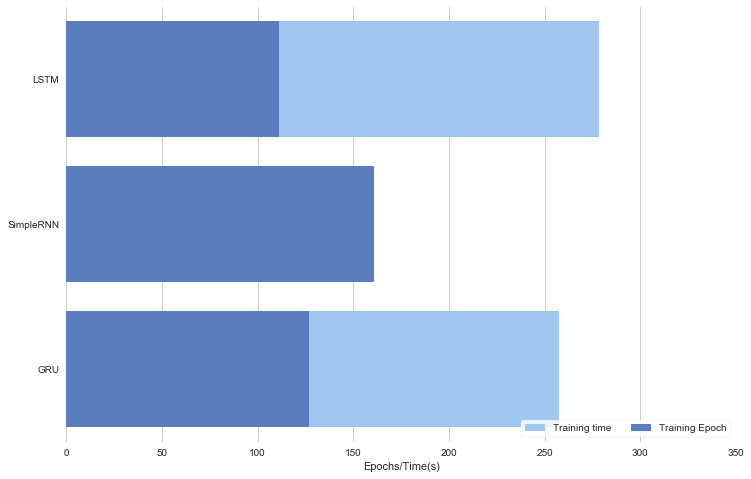

In [30]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 8))

sns.set_color_codes("pastel")
sns.barplot(x=[t1, t2, t3] , y=["LSTM", "SimpleRNN", "GRU"], label="Training time", color="b")

sns.set_color_codes("muted")
sns.barplot(x=[LSTM_steps, SRNN_steps, GRU_steps], y=["LSTM", "SimpleRNN", "GRU"], label="Training Epoch", color="b")



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Epochs/Time(s)")
sns.despine(left=True, bottom=True)
plt.savefig("barplot_softmax.png")
plt.show()

In term of loss TO BE DONE

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


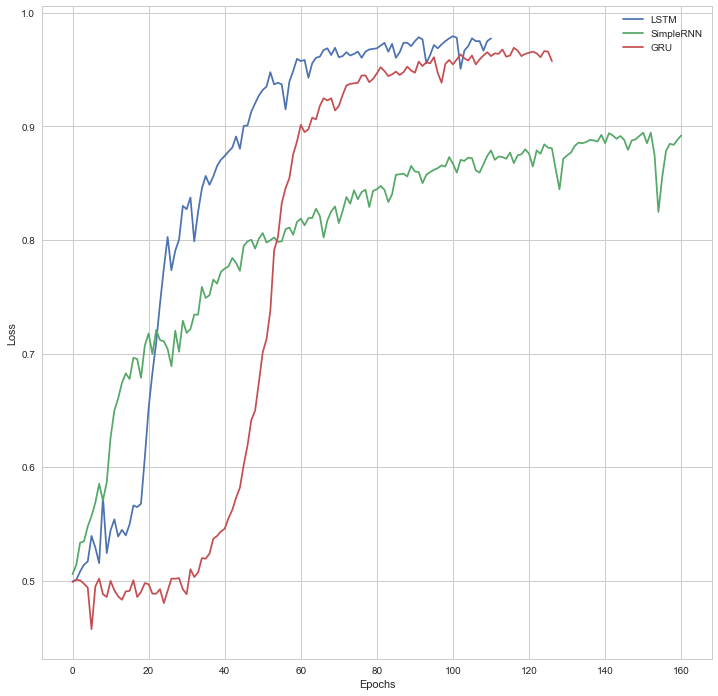

In [31]:
print(history.history.keys())
key_ = list(history.history.keys())[3]
plt.figure(figsize=(12, 12))
plt.plot(history.history[key_], label="LSTM")
plt.plot(history2.history[key_], label="SimpleRNN")
plt.plot(history3.history[key_], label="GRU")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.savefig("loss_softmax.png")
plt.show()

We can see that GRU and LSTM perform better than a Simple RNN. LSTM is also performing slightly better that GRU but require more computation time. We can also check the output and compare it to the real output provided by the graph (see the y description in preparation of data section)

In [75]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, log_loss

In [76]:
y_pred = model.predict(X_eval)

y_pred_floor= np.around(y_pred)

print(accuracy_score(y_eval, y_pred_floor))
print(confusion_matrix(y_eval, y_pred_floor))
print(precision_score(y_eval, y_pred_floor))
print(recall_score(y_eval, y_pred_floor))
print(f1_score(y_eval, y_pred_floor))
print(log_loss(y_eval, y_pred))

0.93359375
[[112  16]
 [  1 127]]
0.888111888112
0.9921875
0.937269372694
0.180792981995


In [77]:
y_pred = model2.predict(X_eval)

y_pred_floor= np.around(y_pred)

print(accuracy_score(y_eval, y_pred_floor))
print(confusion_matrix(y_eval, y_pred_floor))
print(precision_score(y_eval, y_pred_floor))
print(recall_score(y_eval, y_pred_floor))
print(f1_score(y_eval, y_pred_floor))
print(log_loss(y_eval, y_pred))

0.8828125
[[106  22]
 [  8 120]]
0.845070422535
0.9375
0.888888888889
0.335577878227


In [78]:
y_pred = model3.predict(X_eval)

y_pred_floor= np.around(y_pred)

print(accuracy_score(y_eval, y_pred_floor))
print(confusion_matrix(y_eval, y_pred_floor))
print(precision_score(y_eval, y_pred_floor))
print(recall_score(y_eval, y_pred_floor))
print(f1_score(y_eval, y_pred_floor))
print(log_loss(y_eval, y_pred))

0.9296875
[[115  13]
 [  5 123]]
0.904411764706
0.9609375
0.931818181818
0.167904643419


## Conclusion

In this workbook, we started to go through RNN. We check a simple model of both LSTM, GRU and SimpleRNN to check how fast and well they learn. On this example GRU and LSTM outperform the standard RNN due to the memory function. There is also a difference between LSTM and GRU but with slightly more epochs, they both perform similar. We can probably have better result by using a more advanced model but for such a simple model, we can see that it works really well.

## Going further

On a future notebook, we will explore Embedded Reber but using deeper RNNs